<div style="border:solid black 2px; padding: 20px">

 **Золотосодержащая руда**   
    
## Описание проекта

Необходимо подготовить прототип модели, которая увеличит эффективность работы промышленного предприятия.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В нашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Нам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

## Описание данных
    
**Технологический процесс**
- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
    - Xanthate **— ксантогенат (промотер, или активатор флотации);
    - Sulphate — сульфат (на данном производстве сульфид натрия);
    - Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота
    
   
**Параметры этапов**
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи
    
    
## Наименование признаков<br>
    
Наименование признаков должно быть такое:
`[этап].[тип_параметра].[название_параметра]`
    
Пример: rougher.input.feed_ag
    
**Возможные значения для блока [этап]:**
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики
    
**Возможные значения для блока [тип_параметра]:**
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики
    
    
## Этапы исследования
    
[Шаг 1. Подготовка данных](#2)
- [Шаг 1.1 Откроем файлы и изучим их](#1.1)
- [Шаг 1.2 Проверка эффективности обогащения](#1.2)
- [Шаг 1.3 Анализ признаков недоступных в тестовой выборке](#1.3)
- [Шаг 1.4 Предобработка данных](#1.4)

[Шаг 2. Анализ данных](#3)
- [Шаг 2.1 Изменение концентрации металлов](#2.1)
- [Шаг 2.2 Распределение размеров гранул сырья](#2.2)
- [Шаг 2.3 Суммарная концентрация всех веществ](#2.3)
    
[Шаг 3. Модель](#4)
- [Шаг 3.1 Функция для вычисления итоговой sMAPE](#3.1)
- [Шаг 3.2 Обучение моделей и их оценка](#3.2)

[Шаг 4. Общий вывод](#5)
    
[Шаг 5. Чек-лист готовности проекта](#6)

<a id='2'></a>

# Подготовка данных

<a id='1.1'></a>

## Откроем файлы и изучим их

Будем открывать последовательно, а выводы сделаем в конце. <br>
Начнем с файла "train"

In [1]:
# Импортируем все используемые библиотеки

import pandas as pd
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('/datasets/gold_recovery_train.csv')
display(train.head(15))
display(train.info())
display(train.describe())

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
5,2016-01-15 05:00:00,6.482968,10.049416,5.480257,41.633678,69.465816,10.182708,0.664118,16.999638,1.918586,...,13.938497,-500.970168,11.883350,-500.395298,10.054147,-496.374715,7.965083,-499.364752,14.017067,-599.707915
6,2016-01-15 06:00:00,6.533849,10.058141,4.569100,41.995316,69.300835,10.304598,0.807342,16.723575,2.058913,...,14.046819,-500.971133,12.091543,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470
7,2016-01-15 07:00:00,6.130823,9.935481,4.389813,42.452727,70.230976,10.443288,0.949346,16.689959,2.143437,...,13.974691,-501.819696,12.101324,-500.583446,9.873169,-499.171928,7.993381,-499.794518,13.984498,-600.411070
8,2016-01-15 08:00:00,5.834140,10.071156,4.876389,43.404078,69.688595,10.420140,1.065453,17.201948,2.209881,...,13.964030,-504.252450,12.060738,-501.174549,10.033838,-501.178133,7.881604,-499.729434,13.967135,-599.061188
9,2016-01-15 09:00:00,5.687063,9.980404,5.282514,43.235220,70.279619,10.487013,1.159805,17.483979,2.209593,...,13.989632,-503.195299,12.052233,-500.928547,9.962574,-502.986357,7.979219,-500.146835,13.981614,-598.070855


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

None

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,16788.000000,16788.000000,16490.000000,16789.000000,15339.000000,16794.000000,16677.000000,16715.000000,16794.000000,15553.000000,...,16731.000000,16747.000000,16768.000000,16767.000000,16775.000000,16775.000000,16775.000000,16776.000000,16757.000000,16775.000000
mean,4.716907,9.113559,8.301123,39.467217,67.213166,8.757048,2.360327,9.303932,2.687512,129.479789,...,19.101874,-494.164481,14.778164,-476.600082,15.779488,-500.230146,12.377241,-498.956257,18.429208,-521.801826
std,2.096718,3.389495,3.825760,13.917227,11.960446,3.634103,1.215576,4.263208,1.272757,45.386931,...,6.883163,84.803334,5.999149,89.381172,6.834703,76.983542,6.219989,82.146207,6.958294,77.170888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.021781,-0.423260,-799.741097,0.427084,-800.258209,0.024270,-810.473526
25%,3.971262,8.825748,6.939185,42.055722,62.625685,7.610544,1.641604,7.870275,2.172953,103.064021,...,14.508299,-500.837689,10.741388,-500.269182,10.977713,-500.530594,8.925586,-500.147603,13.977626,-501.080595
50%,4.869346,10.065316,8.557228,44.498874,67.644601,9.220393,2.453690,10.021968,2.781132,131.783108,...,19.986958,-499.778379,14.943933,-499.593286,15.998340,-499.784231,11.092839,-499.933330,18.034960,-500.109898
75%,5.821176,11.054809,10.289741,45.976222,72.824595,10.971110,3.192404,11.648573,3.416936,159.539839,...,24.983961,-494.648754,20.023751,-400.137948,20.000701,-496.531781,15.979467,-498.418000,24.984992,-499.565540
max,16.001945,17.031899,18.124851,53.611374,100.000000,19.552149,6.086532,22.317730,9.789625,251.999948,...,60.000000,-127.692333,28.003828,-71.472472,63.116298,-275.073125,39.846228,-120.190931,54.876806,-39.784927


Теперь откроем файл с тестовой выборкой

In [3]:
test = pd.read_csv('/datasets/gold_recovery_test.csv')
display(test.head(15))
display(test.info())
display(test.describe())

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333
5,2016-09-01 05:59:59,168.485085,8.817007,7.420000,0.791191,1402.826803,-499.299521,1401.511119,-499.205357,1404.088107,...,12.029797,-499.814895,8.036586,-500.371492,8.041446,-510.037054,4.983949,-499.990990,24.978973,-500.475640
6,2016-09-01 06:59:59,144.133440,7.924610,7.420000,0.788838,1398.252401,-499.748672,1393.255503,-499.195380,1396.738566,...,12.026296,-499.473127,8.027984,-500.983079,7.907340,-507.964971,5.010224,-500.043697,25.040709,-499.501984
7,2016-09-01 07:59:59,133.513396,8.055252,6.988000,0.801871,1401.669677,-501.777839,1400.754446,-502.514024,1400.465244,...,12.040911,-501.293852,8.020490,-499.185229,8.116897,-511.927561,5.036498,-500.149615,25.032580,-503.970657
8,2016-09-01 08:59:59,133.735356,7.999618,6.935000,0.789329,1402.358981,-499.981597,1400.985954,-496.802968,1401.168584,...,11.998184,-499.481608,8.012610,-500.896783,7.974422,-521.199104,5.061599,-499.791519,25.005063,-497.613716
9,2016-09-01 09:59:59,126.961069,8.017856,7.030000,0.805298,1400.816120,-499.014158,1399.975401,-499.570552,1401.871924,...,12.040725,-499.987743,7.989503,-499.750625,7.989710,-509.946737,5.068811,-499.293900,24.992741,-499.272255


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

None

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5554.000000,5572.000000,5856.000000,5690.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,...,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,170.515243,8.482873,7.264651,1.321420,1481.990241,-509.057796,1486.908670,-511.743956,1468.495216,-509.741212,...,15.636031,-516.266074,13.145702,-476.338907,12.308967,-512.208126,9.470986,-505.017827,16.678722,-512.351694
std,49.608602,3.353105,0.611526,0.693246,310.453166,61.339256,313.224286,67.139074,309.980748,62.671873,...,4.660835,62.756748,4.304086,105.549424,3.762827,58.864651,3.312471,68.785898,5.404514,69.919839
min,0.000103,0.000031,5.650000,0.000003,0.000000,-799.773788,0.000000,-800.029078,0.000000,-799.995127,...,0.000000,-799.798523,0.000000,-800.836914,-0.223393,-799.661076,0.528083,-800.220337,-0.079426,-809.859706
25%,143.340022,6.411500,6.885625,0.888769,1497.190681,-500.455211,1497.150234,-500.936639,1437.050321,-501.300441,...,12.057838,-501.054741,11.880119,-500.419113,10.123459,-500.879383,7.991208,-500.223089,13.012422,-500.833821
50%,176.103893,8.023252,7.259333,1.183362,1554.659783,-499.997402,1553.268084,-500.066588,1546.160672,-500.079537,...,17.001867,-500.160145,14.952102,-499.644328,12.062877,-500.047621,9.980774,-500.001338,16.007242,-500.041085
75%,207.240761,10.017725,7.650000,1.763797,1601.681656,-499.575313,1601.784707,-499.323361,1600.785573,-499.009545,...,18.030985,-499.441529,15.940011,-401.523664,15.017881,-499.297033,11.992176,-499.722835,21.009076,-499.395621
max,274.409626,40.024582,15.500000,5.433169,2212.432090,-57.195404,1975.147923,-142.527229,1715.053773,-150.937035,...,30.051797,-401.565212,31.269706,-6.506986,25.258848,-244.483566,14.090194,-126.463446,26.705889,-29.093593


Откроем файл, содержащий исходные данные

In [4]:
full = pd.read_csv('/datasets/gold_recovery_full.csv')
display(full.head(15))
display(full.info())
display(full.describe())

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
5,2016-01-15 05:00:00,6.482968,10.049416,5.480257,41.633678,69.465816,10.182708,0.664118,16.999638,1.918586,...,13.938497,-500.970168,11.883350,-500.395298,10.054147,-496.374715,7.965083,-499.364752,14.017067,-599.707915
6,2016-01-15 06:00:00,6.533849,10.058141,4.569100,41.995316,69.300835,10.304598,0.807342,16.723575,2.058913,...,14.046819,-500.971133,12.091543,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470
7,2016-01-15 07:00:00,6.130823,9.935481,4.389813,42.452727,70.230976,10.443288,0.949346,16.689959,2.143437,...,13.974691,-501.819696,12.101324,-500.583446,9.873169,-499.171928,7.993381,-499.794518,13.984498,-600.411070
8,2016-01-15 08:00:00,5.834140,10.071156,4.876389,43.404078,69.688595,10.420140,1.065453,17.201948,2.209881,...,13.964030,-504.252450,12.060738,-501.174549,10.033838,-501.178133,7.881604,-499.729434,13.967135,-599.061188
9,2016-01-15 09:00:00,5.687063,9.980404,5.282514,43.235220,70.279619,10.487013,1.159805,17.483979,2.209593,...,13.989632,-503.195299,12.052233,-500.928547,9.962574,-502.986357,7.979219,-500.146835,13.981614,-598.070855


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

None

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,22627.000000,22629.000000,22331.000000,22630.000000,20753.000000,22633.000000,22516.000000,22445.000000,22635.000000,21107.000000,...,22571.000000,22587.000000,22608.000000,22607.000000,22615.000000,22615.000000,22615.000000,22616.000000,22597.000000,22615.000000
mean,4.781559,9.095308,8.640317,40.001172,67.447488,8.923690,2.488252,9.523632,2.827459,140.277672,...,18.205125,-499.878977,14.356474,-476.532613,14.883276,-503.323288,11.626743,-500.521502,17.976810,-519.361465
std,2.030128,3.230797,3.785035,13.398062,11.616034,3.517917,1.189407,4.079739,1.262834,49.919004,...,6.560700,80.273964,5.655791,93.822791,6.372811,72.925589,5.757449,78.956292,6.636203,75.477151
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.836914,-0.423260,-799.741097,0.427084,-800.258209,-0.079426,-810.473526
25%,4.018525,8.750171,7.116799,42.383721,63.282393,7.684016,1.805376,8.143576,2.303108,110.177081,...,14.095940,-500.896232,10.882675,-500.309169,10.941299,-500.628697,8.037533,-500.167897,13.968418,-500.981671
50%,4.953729,9.914519,8.908792,44.653436,68.322258,9.484369,2.653001,10.212998,2.913794,141.330501,...,18.007326,-499.917108,14.947646,-499.612292,14.859117,-499.865158,10.989756,-499.951980,18.004215,-500.095463
75%,5.862593,10.929839,10.705824,46.111999,72.950836,11.084557,3.287790,11.860824,3.555077,174.049914,...,22.998194,-498.361545,17.977502,-400.224147,18.014914,-498.489381,14.001193,-499.492354,23.009704,-499.526388
max,16.001945,17.031899,19.615720,53.611374,100.000000,19.552149,6.086532,22.861749,9.789625,274.409626,...,60.000000,-127.692333,31.269706,-6.506986,63.116298,-244.483566,39.846228,-120.190931,54.876806,-29.093593


Что можно сказать о данных в файлах:
- почти во всех столбцах любого файла присутствуют пропуски
- итоговый файл с исходными данными содержит всю информацию из предыдующих двух.
- в обучающей выборке есть все признаки, содержащиеся в тестовой.

<a id='1.2'></a>

## Проверка эффективности обогащения

Вычислим её на обучающей выборке для признака "rougher.output.recovery". <br>
Найдем MAE между нашими расчётами и значениями признака.

Для этого организуем временные датасет, и удалим из него все пропуски.

In [5]:
train_without_nan = train.dropna(subset = train.columns)

# доля золота в концентрате после флотации
C = train_without_nan['rougher.output.concentrate_au']
# доля золота в сырье до флотации
F = train_without_nan['rougher.input.feed_au']
# доля золота в отвальных хвостах после флотации
T = train_without_nan['rougher.output.tail_au']


# Формула эффективности обогащения
recovery = C*(F-T) / (F*(C-T)) *100


# MAE 
mae = mean_absolute_error(train_without_nan['rougher.output.recovery'], recovery)

print('MAE:', mae)

MAE: 9.555596961987514e-15


Среднее абсолютное отклонение мало настолько, будто его совсем нет.
Выходит, что эффективность обогащения рассчитана правильно.

<a id='1.3'></a>

## Анализ признаков недоступных в тестовой выборке

Нарочно выведем ошибку "KeyError", ведь она покажет какие признаки (столбцы) отсутствуют в тестовой выборке относительно обучающей.

Посмотрим, сделаем выводы и закомментируем, иначе весь последующий код работать не будет.

In [6]:
#test[train.columns]

Видим, что в тестовом файле нет множества столбцов, которые заключают в себе [тип_параметра] = 'output', либо 'calculation'. Т.е. отсутствуют те данные, которые связаны с параметрами продукта и расчетными характеристиками.<br>
Другими словами: нет признаков, которые появляются уже в процессе обработки.<br>
Поэтому их следует удалить из обучающей выборки перед обучением моделей, но это в пункте 3.2

<a id='1.4'></a>

In [7]:
print(set(train.columns) - set(test.columns))

{'final.output.concentrate_ag', 'secondary_cleaner.output.tail_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_sol', 'final.output.tail_ag', 'primary_cleaner.output.tail_ag', 'final.output.concentrate_sol', 'primary_cleaner.output.concentrate_pb', 'rougher.output.tail_pb', 'final.output.concentrate_au', 'rougher.output.concentrate_au', 'final.output.tail_sol', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.output.tail_au', 'primary_cleaner.output.tail_au', 'rougher.output.recovery', 'rougher.output.tail_sol', 'secondary_cleaner.output.tail_sol', 'primary_cleaner.output.concentrate_ag', 'rougher.output.tail_ag', 'rougher.output.concentrate_sol', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'secondary_cleaner.output.tail_ag', 'rougher.output.concentrate_ag', 'final.output.concentrate_pb', 'rougher.calculation.sulfate_to_au_concen

## Предобработка данных

Конкретная дата и время нам толком не нужны, разве что для заполнения пропусков (но об этом ниже) и поиска всех измерений тестовой выборки в полных данных для анализа качества обучаемой модели.<br>
P.S. Перед обучением их стоит удалить, т.к. это будет создавать лишний шум.

Теперь заполним пропуски в таблицах.

Что будет, если мы удалим все строки, в которых встречается хотя бы один пропуск? Много ли мы потеряем ? <br>
Проверим это.

In [8]:
a = train.dropna(subset = train.columns)
a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11017 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  11017 non-null object
final.output.concentrate_ag                           11017 non-null float64
final.output.concentrate_pb                           11017 non-null float64
final.output.concentrate_sol                          11017 non-null float64
final.output.concentrate_au                           11017 non-null float64
final.output.recovery                                 11017 non-null float64
final.output.tail_ag                                  11017 non-null float64
final.output.tail_pb                                  11017 non-null float64
final.output.tail_sol                                 11017 non-null float64
final.output.tail_au                                  11017 non-null float64
primary_cleaner.input.sulfate                         11017 non-null float64
primary_cleaner.input.depressant             

Почти 6 тыс. измерений коту под хвост - около 35% данных. Нам такой вариант не подходит.

Тогда можно найти корреляцию между признаками и заполнить пропуски на ее основе. Однако, это достаточно долгая процедура. Поэтому..

..вспомним описание проекта: "данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи".<br>
В связи с этим, применим метод "ffill", который распространяет последнее действительное наблюдение вперед к следующему действительному.

(P.S. метод "ffill" учитывает описание проекта, однако пренебрегает признаком "date", именно поэтому время и дата нам не нужны)

In [9]:
train = train.dropna(subset = ['final.output.recovery', 'rougher.output.recovery'])
train = train.ffill()
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14149 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  14149 non-null object
final.output.concentrate_ag                           14149 non-null float64
final.output.concentrate_pb                           14149 non-null float64
final.output.concentrate_sol                          14149 non-null float64
final.output.concentrate_au                           14149 non-null float64
final.output.recovery                                 14149 non-null float64
final.output.tail_ag                                  14149 non-null float64
final.output.tail_pb                                  14149 non-null float64
final.output.tail_sol                                 14149 non-null float64
final.output.tail_au                                  14149 non-null float64
primary_cleaner.input.sulfate                         14149 non-null float64
primary_cleaner.input.depressant             

Итак, ни одного пропуска, Vivat! 

Проведем ту же процедуру с тестовым и полным набором данных.

In [10]:
# Для теста удалять строки с пропусками в целевых столбцах не предоставляется возможным
# т.к. эти столбцы отсутствуют. Просто заполним пропуски.
test = test.ffill()

full = full.dropna(subset = ['final.output.recovery', 'rougher.output.recovery'])
full = full.ffill()

Последний штрих перед анализом - проверим на дубликаты.

In [11]:
print(train.duplicated().sum())
print(test.duplicated().sum())
print(full.duplicated().sum())

0
0
0


Отлично, едем дальше.

<a id='3'></a>

# Анализ данных

<a id='2.1'></a>

## Изменение концентрации металлов

<a id='2.2'></a>

Распределение концентраций Au-металла на различных этапах очистки


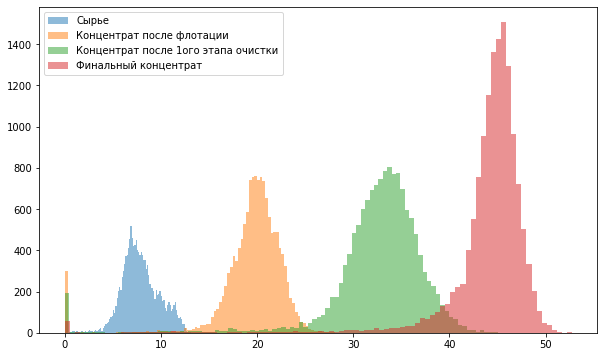

Распределение концентраций Ag-металла на различных этапах очистки


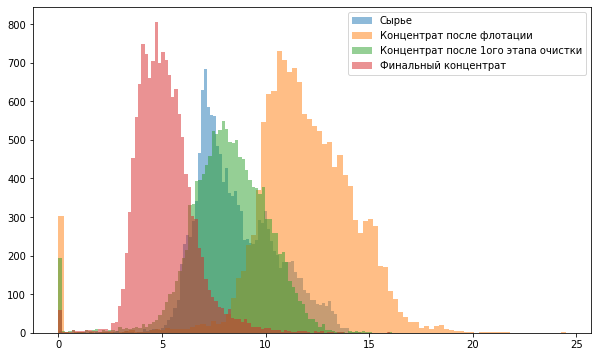

Распределение концентраций Pb-металла на различных этапах очистки


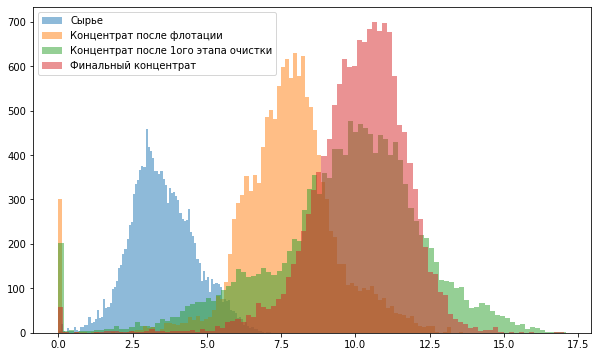

In [13]:
# Напишем функцию, отрисовывающую график-гистограмму концентрации металла на каждом этапе 
 
def concentrate_metal_(rougher_input, rougher_output, primary_cleaner, final_output):
    plt.figure(figsize=(10,6))
    plt.hist(rougher_input, bins = 100, label = 'Сырье', alpha = 0.5)
    plt.hist(rougher_output, bins = 100, label = 'Концентрат после флотации', alpha = 0.5)
    plt.hist(primary_cleaner, bins = 100, label = 'Концентрат после 1ого этапа очистки', alpha = 0.5)
    plt.hist(final_output, bins = 100, label = 'Финальный концентрат', alpha = 0.5)
    plt.legend()
    plt.show()
    

print('Распределение концентраций Au-металла на различных этапах очистки')
concentrate_metal_(train['rougher.input.feed_au'], 
                   train['rougher.output.concentrate_au'], 
                   train['primary_cleaner.output.concentrate_au'], 
                   train['final.output.concentrate_au'])

print('Распределение концентраций Ag-металла на различных этапах очистки')
concentrate_metal_(train['rougher.input.feed_ag'], 
                   train['rougher.output.concentrate_ag'], 
                   train['primary_cleaner.output.concentrate_ag'], 
                   train['final.output.concentrate_ag'])

print('Распределение концентраций Pb-металла на различных этапах очистки')
concentrate_metal_(train['rougher.input.feed_pb'], 
                   train['rougher.output.concentrate_pb'], 
                   train['primary_cleaner.output.concentrate_pb'], 
                   train['final.output.concentrate_pb'])

Можем наблюдать, что концентрации золота и свинца последовательно растут, однако свинец прибавляет в росте незначительно. А вот концентрация серебра плавает в рамках (0,20) единиц, причем растет до 2ого этапа включительно, а после идет на снижение.

## Распределение размеров гранул сырья

Распределение гранул сырья стоит проверить исключительно на этапе загрузки сырья во флотационную установку (признак 'rougher.input.feed_size'), т.к. далее они проходят идентичные процессы переработки.

Проверим на диаграмме размаха.

Text(0.5, 1.0, 'Тестовая выборка')

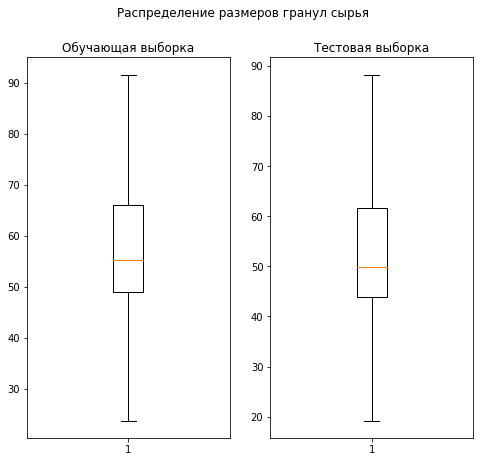

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(8, 7))
axs[0].boxplot(train['rougher.input.feed_size'], showfliers = False)
axs[1].boxplot(test['rougher.input.feed_size'], showfliers = False)
fig.suptitle('Распределение размеров гранул сырья')
axs[0].set_title('Обучающая выборка')
axs[1].set_title('Тестовая выборка')

Распределение размеров гранул сырья почти идентичное.<br>
Модель будет работать правильно.

<a id='2.3'></a>

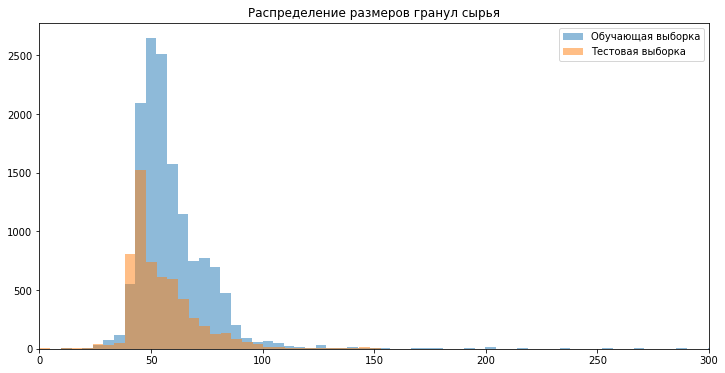

In [15]:
plt.figure(figsize=(12,6))
plt.xlim(0,300)
plt.hist(train['rougher.input.feed_size'], bins = 100, label = 'Обучающая выборка', alpha = 0.5)
plt.hist(test['rougher.input.feed_size'], bins = 100, label = 'Тестовая выборка', alpha = 0.5)
plt.legend()
plt.title('Распределение размеров гранул сырья')
plt.show()

## Суммарная концентрация всех веществ на разных стадиях

Просуммируем концентрации всех металлов (Au, Ag, Pb) на каждой стадии.<br>
После чего посмотрим на их распределения.

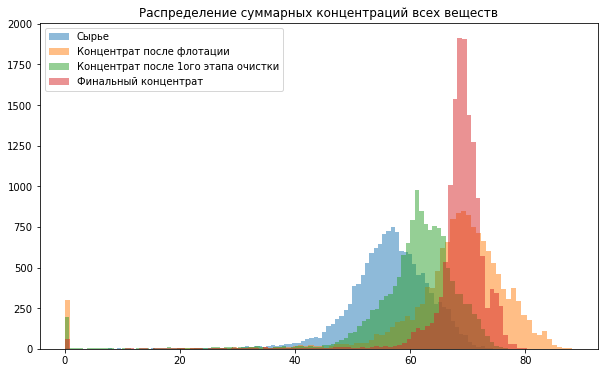

(14149, 91)


In [16]:
def sum_concentrate(data):
    # Сырье
    data['sum_before'] = (data['rougher.input.feed_ag'] + 
                          data['rougher.input.feed_au'] + 
                          data['rougher.input.feed_pb'] + 
                          data['rougher.input.feed_sol'])


    # Концентрат после флотации
    data['sum_rougher'] = (data['rougher.output.concentrate_au'] + 
                           data['rougher.output.concentrate_ag'] + 
                           data['rougher.output.concentrate_pb'] + 
                           data['rougher.output.concentrate_sol'])


    # Концентрат после 1ого этапа очистки
    data['sum_primary'] = (data['primary_cleaner.output.concentrate_au'] + 
                           data['primary_cleaner.output.concentrate_ag'] + 
                           data['primary_cleaner.output.concentrate_pb'] + 
                           data['primary_cleaner.output.concentrate_sol'])


    # Финальный концентрат
    data['sum_final'] = (data['final.output.concentrate_au'] + 
                         data['final.output.concentrate_ag'] + 
                         data['final.output.concentrate_pb'] + 
                         data['final.output.concentrate_sol'])
    
    return data['sum_before'], data['sum_rougher'], data['sum_primary'], data['sum_final']

train['sum_before'], train['sum_rougher'], train['sum_primary'], train['sum_final'] = sum_concentrate(train)

# Построим график
def concentrate_grafic(data):
    plt.figure(figsize=(10,6))
    plt.hist(data['sum_before'], bins = 100, label = 'Сырье', alpha = 0.5)
    plt.hist(data['sum_rougher'], bins = 100, label = 'Концентрат после флотации', alpha = 0.5)
    plt.hist(data['sum_primary'], bins = 100, label = 'Концентрат после 1ого этапа очистки', alpha = 0.5)
    plt.hist(data['sum_final'], bins = 100, label = 'Финальный концентрат', alpha = 0.5)
    plt.legend()
    plt.title('Распределение суммарных концентраций всех веществ')
    plt.show()
    print(data.shape)
    
concentrate_grafic(train)

Видим аномальные значения в нуле.<br>
Катали пустую руду по всем этапам?<br>
Не может быть, чтобы концентрация на любом из этапов была равна 0 или была приближена к нему, в то время, как на всех последующих или предыдущих этапах равнялась какому-то числу или была значительно больше. У нас не алхимия и не чудо-техника, а настоящее реальное производство. <br>
Удалим выбросы.<br>
Для ограничения по удалению возьмем навскидку околонулевое значение = 0.5

In [17]:
def udalenie_vibrosov(data):
    data_01 = data.drop(np.where(data['sum_before'] < 0.5)[0]).reset_index(drop = True)
    data_02 = data_01.drop(np.where(data_01['sum_rougher'] < 0.5)[0]).reset_index(drop = True)
    data_03 = data_02.drop(np.where(data_02['sum_primary'] < 0.5)[0]).reset_index(drop = True)
    data_04 = data_03.drop(np.where(data_03['sum_final'] < 0.5)[0]).reset_index(drop = True)
       
    return data_04

train = udalenie_vibrosov(train)
train.shape

(13595, 91)

Около 15% данных некорректны. Мы избавились от них.<br>
Посмотрим на распределение суммарных концентраций теперь.

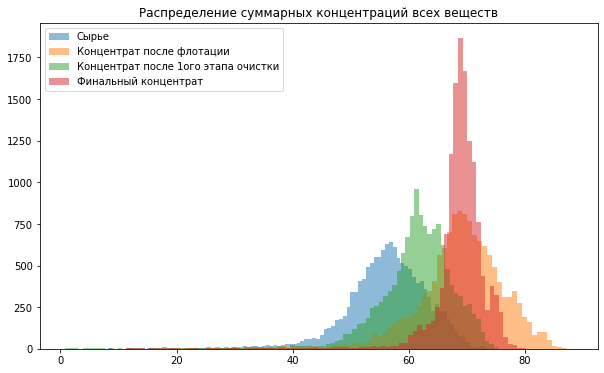

(13595, 91)


In [18]:
concentrate_grafic(train)

От выбросов избавились, перейдем к обучению модели.

<a id='4'></a>

In [20]:
full['sum_before'], full['sum_rougher'], full['sum_primary'], full['sum_final'] = sum_concentrate(full)
full = udalenie_vibrosov(full)
print(test.shape)

# Перезапишем тестовую выборку без выбросов, путем ее индентификации в полных данных, которые мы уже почистили от выбросов
test = test.loc[test['date'].isin(full['date'])]
test.shape

(5856, 53)


(5118, 53)

# Модель

<a id='3.1'></a>

## Функция для вычисления итоговой sMAPE

In [21]:
def smape(target, prediction):
    smape =  (1 / len(target) * np.sum(2 * np.abs(target - prediction) / (np.abs(target) + np.abs(prediction)))) * 100
    return smape

In [22]:
smape_scorer = make_scorer(smape, greater_is_better = False)

<a id='3.2'></a>

## Обучение моделей и их оценка

Т.к. нам нужно спрогнозировать величины эффективности обогащения **на входных параметрах**, перед обучением стоит удалить из обучающей выборки те признаки, которые получаем уже непосредственно в процессе очистки и флотации. Т.е. столбцы, являющиеся выходными параметрами (с этим нам как раз поможет отличие признаков тестовой и обучающей выборок).<br>

Удалим из обучающей выборки те признаки, которых нет в тестовой, оставив целевые.

In [23]:
# Создадим датасет, окончательно утвержденный к обучению 
train_01 = train[test.columns]
train_01['rougher.output.recovery'] = train['rougher.output.recovery']
train_01['final.output.recovery'] = train['final.output.recovery']

# Не забываем почистить датасет от излишних шумов
train_01 = train_01.drop('date', axis = 1)

# Однако, перед удалением этого признака из теста, нужно идентифицировать данные тестовой выборки, 
# которые содержатся в полном наборе, чтобы потом проверить качество обученной модели.

full_isin_test = full.loc[full['date'].isin(test['date'])]

# Теперь удалим шум
test = test.drop('date', axis = 1)

Теперь все готово для обучения, начнем.

### Дерево решений

Обучим дерево решений, подобрав через GridSearchCV лучшие гиперпараметры.<br>
Оценим нашей метрикой sMAPE.

In [24]:
%%time

# Выделим целевые признаки 
features = train_01.drop(['rougher.output.recovery', 'final.output.recovery'], axis = 1)
target_rougher = train_01['rougher.output.recovery']
target_final = train_01['final.output.recovery']


# Обучим модель для признака 'rougher.output.recovery'
tree = {'max_depth': range(1, 11)}
model_tree = DecisionTreeRegressor(random_state = 12345)
grid_tree_rougher = GridSearchCV(model_tree, tree, cv = 5, scoring = smape_scorer)
grid_tree_rougher.fit(features, target_rougher)
print('sMAPE для признака "rougher.output.recovery":', abs(grid_tree_rougher.best_score_))
print()
print(grid_tree_rougher.best_estimator_)


print()
print()


# Обучим модель для признака 'final.output.recovery'
model_tree_final = DecisionTreeRegressor(random_state = 12345)
grid_tree_final = GridSearchCV(model_tree_final, tree, cv = 5, scoring = smape_scorer)
grid_tree_final.fit(features, target_final)
print('sMAPE для признака "final.output.recovery":', abs(grid_tree_final.best_score_))
print()
print(grid_tree_final.best_estimator_)

sMAPE для признака "rougher.output.recovery": 6.815271435975766

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=12345, splitter='best')


sMAPE для признака "final.output.recovery": 9.239980869562073

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=12345, splitter='best')
CPU times: user 25.8 s, sys: 11.5 ms, total: 25.8 s
Wall time: 25.9 s


**Посмотрим итоговый sMAPE**

In [25]:
def final_smape(rougher, final):
    final_smape = 0.25 * (rougher) + 0.75 * (final)
    print('Итоговый sMAPE:', final_smape)
    
final_smape(abs(grid_tree_rougher.best_score_), abs(grid_tree_final.best_score_))

Итоговый sMAPE: 8.633803511165496


По нашей метрике лучший результат = 0 (т.к. smape = 0 при идеальном варианте, когда предсказание совпадает с целевым признаком).<br>
Т.е. мы гонимся за максимально приближенным к нулю результатом.

### Случайный лес

Случайный лес обучим путем кросс-валидации. Уж больно долго он перебирает параметры при GridSearchCV.

In [26]:
%%time


# Обучим модель для признака 'rougher.output.recovery'

model_forest_rougher = RandomForestRegressor(random_state = 1234)
cross_forest_rougher = cross_val_score(model_forest_rougher,features, target_rougher, cv = 5, scoring = smape_scorer)
mean_smape_rougher = abs(cross_forest_rougher).mean()
print('sMAPE для признака "rougher.output.recovery":', mean_smape_rougher)
print()


# Обучим модель для признака 'final.output.recovery'

model_forest_final = RandomForestRegressor(random_state = 1234)
cross_forest_final = cross_val_score(model_forest_final, features, target_final, cv = 5, scoring = smape_scorer)
mean_smape_final = abs(cross_forest_final).mean()
print('sMAPE для признака "final.output.recovery":', mean_smape_final)
print()


# Найдем итоговый sMAPE

final_smape(mean_smape_rougher, mean_smape_final)
print()

sMAPE для признака "rougher.output.recovery": 6.840163507618364

sMAPE для признака "final.output.recovery": 10.487895758262669

Итоговый sMAPE: 9.575962695601593

CPU times: user 43.4 s, sys: 4.76 ms, total: 43.4 s
Wall time: 43.4 s


### Линейная регрессия

С линейной регрессией поступим таким же образом. Применим кросс-валидацию, т.к. никаких параметров перебирать не надо.

In [27]:
%%time


# Обучим модель для признака 'rougher.output.recovery'

model_linear_rougher = LinearRegression()
cross_linear_rougher = cross_val_score(model_linear_rougher, features, target_rougher, cv = 5, scoring = smape_scorer)
mean_smape_rougher = abs(cross_linear_rougher).mean()
print('sMAPE для признака "rougher.output.recovery":', mean_smape_rougher)
print()


# Обучим модель для признака 'final.output.recovery'
model_linear_final = LinearRegression()
cross_linear_final = cross_val_score(model_linear_final, features, target_rougher, cv = 5, scoring = smape_scorer)
mean_smape_final = abs(cross_linear_final).mean()
print('sMAPE для признака "final.output.recovery":', mean_smape_final)
print()

# Найдем итоговый sMAPE

final_smape(mean_smape_rougher, mean_smape_final)
print()

sMAPE для признака "rougher.output.recovery": 7.291941729934858

sMAPE для признака "final.output.recovery": 7.291941729934858

Итоговый sMAPE: 7.291941729934858

CPU times: user 1.16 s, sys: 1.54 s, total: 2.69 s
Wall time: 2.66 s


Удаление выбросов из тестовой выборки на основе данных из фулл значительно повлияло на изменение результатов нашей метрики, они улучшились.
    
Соответственно улучшились  результаты проверки теста.

**Итого:** лучшие результаты метрики у линейной регрессии.<br>
Движемся к заключению.

**Проверим на тестовой выборке.**

In [28]:
# Чтобы сделать проверку, нам необходимы данные целевых признаков для тестовой выборки из полного датасета
# В пункте 3.2 мы их идентифицировали и положили в переменную "full_isin_test"
# Теперь выделим из нее целевые признаки

target_rougher_test = full_isin_test['rougher.output.recovery']
target_final_test = full_isin_test['final.output.recovery']

# признак 'rougher.output.recovery'
model_linear_rougher.fit(features, target_rougher)
prediction_test_rougher = model_linear_rougher.predict(test)
smape_test_rougher = smape(target_rougher_test, prediction_test_rougher)
print('sMAPE для признака "rougher.output.recovery":', smape_test_rougher)
print()

# признак 'final.output.recovery'
model_linear_final.fit(features, target_final)
prediction_test_final = model_linear_final.predict(test)
smape_test_final = smape(target_final_test, prediction_test_final)
print('sMAPE для признака "final.output.recovery":', smape_test_final)
print()

# Итоговый sMAPE
final_smape(smape_test_rougher, smape_test_final)

sMAPE для признака "rougher.output.recovery": 4.928068919219861

sMAPE для признака "final.output.recovery": 8.138027441350514

Итоговый sMAPE: 7.335537810817851


**Итоговый sMAPE: 7.335537810817851**

<a id='5'></a>

# Общий вывод

Интересное наблюдение на счет суммарных концентраций металлов: по ходу обработки концентрация золота увеличивается (что не является удивительным), а вместе с ним и свинец, однако что на счет серебра? Сначала его концентрация увеличивается, но в последствии уменьшается. Вероятно, это связано с тонкостями обработки, влияющие на его нахождение в общем составе.


Также стоит помнить, что при изменении размера гранул сырья, модель может неправильно сработать.

Что ж, мы научились предсказывать коэффициенты восстановления золота из золотосодержащей руды, а именно эффективность обогащения чернового и финального концентратов.

Наши предсказания граничат с настоящими данными в среднем с погрешностью +-7%.


Много это или мало для оптимизации производства ? Трудный вопрос, необходимо понимать тонкости этой отрасли.<br>
Однако запуск предприятия с убыточными характеристиками, имея такой результат исследования, маловероятен.

<a id='6'></a>